# Test the Pipeline
In this notebook we just test the implemented modules to verify that everything works.

## Notes
- If we want to apply mixup, we have to do so before passing the data to the model. In their implementation, when the model is in training mode, it gets both x and y and computes the mixup during the forward call. The way we have set this up here, the model expects *only* x, so if we want Mixup, we have to do so on the batch _before_ passing it to the model.
- The modules themselves are still very simple and can be improved/we can add more functionality to them. 

In [2]:
%load_ext autoreload
%autoreload 2 

import sys
 
# setting path
sys.path.append('../')

from modules.TransformApplier import TransformApplier 
from modules.Wav2Spec import Wav2Spec
from modules.SimpleDataset import SimpleDataset
from modules.PretrainedModel import *
from modules.OnlyXTransform import OnlyXTransform
from modules.SelectSplitData import * 
from modules.SimpleAttention import *

import pandas as pd 
import torch.nn as nn
import torch
import timm
import json
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np 

/home/fredrik/Documents/School/S9/AI4Good/ai4good_code/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
DATA_PATH = '../birdclef-2022/'
metadata = pd.read_csv(f'{DATA_PATH}train_metadata.csv')# [:4000]

with open(f'{DATA_PATH}scored_birds.json') as f:
    birds = json.load(f)

In [59]:
dataset = SimpleDataset(metadata, DATA_PATH, labels=birds)

## Define pipelines

In [60]:
bs = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_splits = 6
duration = 30 
def collate_fn(data):
    max_dim = max([d[0].shape[-1] for d in data])
    pad_x = lambda x: torch.concat([x, torch.zeros((max_dim - x.shape[-1], ))])
    return torch.stack([pad_x(d[0]) for d in data], axis=0), torch.stack([torch.tensor(d[1]) for d in data])

tts = metadata.sample(frac=.05).index # train test split
df_val = metadata.iloc[tts]
df_train = metadata.iloc[~tts]

train_data = SimpleDataset(df_train, DATA_PATH, mode='train', labels=birds)
val_data = SimpleDataset(df_val, DATA_PATH, mode='train', labels=birds)

# create mode
transforms1 = TransformApplier(
    [
        # SelectSplitData(duration, n_splits, sr=16000), 
        nn.Identity()
    ]
)

wav2spec = Wav2Spec(
    # n_fft=1024, 
    # sample_rate=16000, 
    # win_length=None, 
    
)

transforms2 = TransformApplier(
    [
        SelectSplitData(duration, n_splits, sr=128), 
        nn.Identity()
    ]
)

cnn = PretrainedModel(
    model_name='efficientnet_b2', 
    in_chans=1, # normally 3 for RGB-images
)

transforms3 = TransformApplier([SimpleAttention(cnn.get_out_dim()), RejoinSplitData(duration, n_splits)])

output_head = OutputHead(n_in=cnn.get_out_dim() * n_splits, n_out=21)

data_pipeline_train = nn.Sequential(
    transforms1, 
    wav2spec,
    transforms2, 
).to(device)

data_pipeline_val = nn.Sequential(
    transforms1, 
    wav2spec, 
).to(device) # Leaving out transforms2 since I think it will mostly be relevant for training

model = nn.Sequential(
    cnn,
    transforms3, 
    output_head,
    # transforms4
).to(device)

In [61]:
train_loader = DataLoader(train_data[:1000], batch_size=bs, num_workers=8, collate_fn=collate_fn)
val_loader = DataLoader(val_data[:50], batch_size=bs, num_workers=8, collate_fn=collate_fn)
iter_loader = iter(train_loader)
d = next(iter_loader)
out_train_pipeline = data_pipeline_train(d)
print([i.shape for i in out_train_pipeline])
print(out_train_pipeline[-1])

FAIL READING rec ../birdclef-2022/train_audio/0      bknsti/XC395772.ogg
1      eurwig/XC522536.ogg
2      eurwig/XC134682.ogg
3      pagplo/XC599330.ogg
4      masboo/XC233873.ogg
              ...         
738    rorpar/XC600866.ogg
739    peflov/XC453162.ogg
740    laugul/XC333002.ogg
741    hawama/XC503722.ogg
742    wesmea/XC418077.ogg
Name: filename, Length: 743, dtype: object


/home/fredrik/Documents/School/S9/AI4Good/ai4good_code/venv/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


UnboundLocalError: local variable 'wav' referenced before assignment

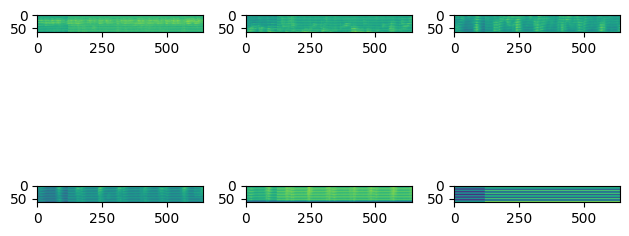

In [39]:
w = 2
h = n_splits // w
fig, axs = plt.subplots(w, n_splits // w)
if h > 1:
    for i in range(w):
        for j, ax in enumerate(axs[i]):
            ax.imshow(out_train_pipeline[0][i * h + j])
else:
    for i, ax in enumerate(axs):
        ax.imshow(out_train_pipeline[0][i])
fig.tight_layout()
plt.show()

In [64]:
def find_positive(dataset):
    primary_labels = np.stack(dataset.primary_label)
    secondary_labels = np.stack(dataset.secondary_label)
    labels = primary_labels + secondary_labels
    return np.argwhere(labels.max(axis=1)>0)

(1464, 1)


In [8]:
# import numpy as np
# for i in range(1000):
#     d = dataset.__getitem__(i, debug=False)
#     if np.sum(d[-1]) > 2:
#         dataset.__getitem__(i, debug=True)
#         print(i, d)
#         break

with open(f'{DATA_PATH}scored_birds.json') as f:
        birds = json.load(f)

metadata = pd.read_csv(f'{DATA_PATH}train_metadata.csv')
# choose only samples with a positive label
full_dataset = SimpleDataset(metadata, DATA_PATH, mode='train', labels=birds)

def find_positive(dataset, N, metadata):
    """
    return a dataset with N positive samples
    """
    found = 0
    i = 0
    ids = []
    while found < N and i < len(dataset):
        lbl = dataset[i][1]
        if lbl.sum() > 0:
            found = found + 1
            ids.append(i)
        i = i + 1
    return metadata.iloc[ids]
metadata = find_positive(full_dataset, N=100, metadata=metadata)

FAIL READING rec ../birdclef-2022/train_audio/akepa1/XC175511.ogg


UnboundLocalError: local variable 'wav' referenced before assignment

In [ ]:
import numpy as np
reduced_dataset = SimpleDataset(metadata, DATA_PATH, mode='train', labels=birds)
print([reduced_dataset[i][-1].sum() for i in range(100)])

[2, 1, 1, 5, 3, 2, 3, 5, 3, 2, 2, 1, 1, 4, 4, 2, 7, 6, 4, 5, 1, 3, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 4, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
